### Project Topic

This project applies deep learning techniques to classify fungal specimens from image data. The dataset (cited below) consists of high-resolution color images of fungal samples labeled into five classes: H1, H2, H3, H5, and H6. Each image captures morphological characteristics such as color, texture, and shape, which are used as input features for model training. In this project EfficientNet and ResNet models were applied to evaluate their effectiveness in automated biological image classification. By comparing model performance, the project aims to highlight the strengths and limitations of these approaches for real-world biological imaging tasks.

The primary models used in this project are EfficientNetB0 and ResNet50, trained with class-weighting and fine-tuning strategies to handle class imbalance and improve generalization.

### Data Source

This dataset uses the DeFungi dataset retrieved from the UCI Machine Learning Repository.

Paper link: https://arxiv.org/abs/2109.07322

Citation:
Hajati, F., Javier Pineda Sopo, C., Hajati, F., & Gheisari, S. (2021). DeFungi [Dataset]. UCI Machine Learning Repository. https://doi.org/10.48550/arXiv.2109.07322.


### Project Goal

The primary goal of this project is to explore and evaluate deep learning approaches for classifying fungal images. Understanding how different fungal species can be distinguished from images is important for biological research, ecological monitoring, and potential public health applications. Automated classification tools can support researchers, educators, and field biologists in identifying fungal specimens accurately, reducing manual effort and improving consistency in large-scale biological studies.

The project aims to:

- Train and fine-tune EfficientNetB0 and ResNet50 to classify fungal specimens based on image features.
- Compare the performance of models using metrics such as accuracy, F1-score, and confusion matrices, identifying patterns in misclassifications.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import pathlib
from PIL import Image
import keras_tuner as kt

### Data Description
The dataset consists of 9,114 labeled images across 5 classes: H1, H2, H3, H5, and H6.
Classes and counts:
- H1: 4,404 images
- H2: 2,334 images
- H3: 819 images
- H5: 818 images
- H6: 739 images


Data split:
- Training set: 7,290 images (80%)
- Validation set: 1,824 images (20%)

Image format: JPEG (.jpg) files.

Image properties:
- All images are color (3 channels, RGB).
- Images were resized to a fixed dimension of 224×224 pixels for training.
- Original image sizes were 500x500.

### Data Cleaning
Several cleaning steps were performed to ensure the dataset was usable and consistent.

Corrupted Images:
- Checked all files for validity by validating the correct file type, and ensure they were not corrupted.
- All files were valid, so no images were removed.

Image resizing:
- The raw images were 500x500 pixels. All images were resized to 224×224 pixels as smaller images reduce computation and memory usage, allowing faster training and larger batch sizes.
- The resized dimension(224x224) matches the input size of most pretrained models, including EfficientNet, enabling effective use of pretrained weights.
- Downscaling helps the model focus on generalizable features by removing irrelevant high-resolution noise.

Class imbalance awareness:
- The dataset was imbalanced: H1 (4,404 images) and H2 (2,334) had far more samples than H3 (819), H5 (818), and H6 (739).
- This was addressed during training by using class weights.

Skipped 0 unreadable images.
Collected dimensions for 9114 images.


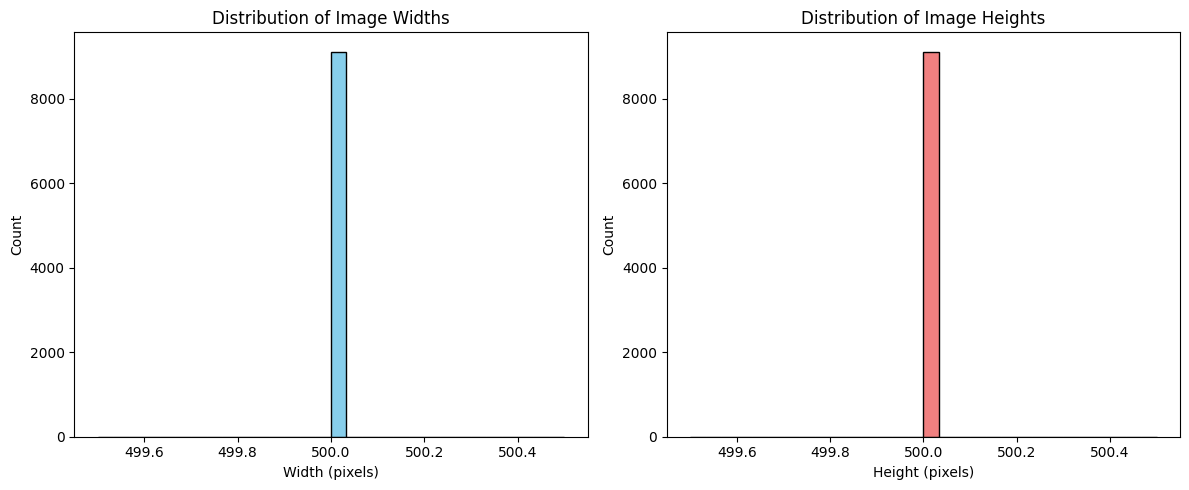

In [ ]:
# Define base directory and class names
base_dir = "data/defungi"
class_names = ["H1", "H2", "H3", "H5", "H6"]
num_skipped = 0
data_dir = pathlib.Path(base_dir)

widths = []
heights = []

for folder_name in class_names:
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with Image.open(fpath) as img:
                img.load()  # load image to ensure it’s not corrupted
                w, h = img.size
                widths.append(w)
                heights.append(h)

        except Exception as e:
            num_skipped += 1
            print(f"Skipped {fpath}, reason: {e}")
            os.remove(fpath) #delete corrupted image

print(f"Skipped {num_skipped} unreadable images.")
print(f"Collected dimensions for {len(widths)} images.")

#Plot Histogram of image dimensions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color="lightcoral", edgecolor="black")
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



In [ ]:
# Create train and validation directories
train_dir = "data/defungi_train"
val_dir = "data/defungi_val"
class_names = ["H1", "H2", "H3", "H5", "H6"]

for d in [train_dir, val_dir]:
    for c in class_names:
        os.makedirs(os.path.join(d, c), exist_ok=True)

# Split files stratified by class
for c in class_names:
    files = [f for f in os.listdir(os.path.join(base_dir, c)) if f.lower().endswith((".jpg", ".png"))]
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42, shuffle=True)

    for f in train_files:
        shutil.copy(os.path.join(base_dir, c, f), os.path.join(train_dir, c, f))
    for f in val_files:
        shutil.copy(os.path.join(base_dir, c, f), os.path.join(val_dir, c, f))


In [ ]:
# Create train and test datasets
image_size = (224, 224)
batch_size = 64

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names,
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names,
    shuffle=False
)



Found 7290 files belonging to 5 classes.
Found 1824 files belonging to 5 classes.


### Exploratory Data Analysis

Class Distribution:
- Visualized number of samples in each class.
- Found that some classes have more images than others, leading to potential class imbalance.

Image Samples:
- Displayed sample images from each class.
- Helps to qualitatively assess dataset quality and variation.

Color Channel Analysis:
- Plotted RGB channel distributions for each class.
- Observed differences in brightness/contrast and possible overlaps across classes.

Key Takeaways:
- Dataset shows class imbalance, which will require class weighting or augmentation.
- Some classes are visually distinct, while others are more subtle. This could lead to confusion during class identifications.
- Data augmentation will be applied to help with image variation (rotation, zoom, flip).


H1 mean per channel: [134.79957904 137.05575392 134.05053576]
H2 mean per channel: [135.56136832 135.9931948  130.07818224]
H3 mean per channel: [139.1147724  136.57472968 130.90221352]
H5 mean per channel: [142.34846632 139.02368048 126.09985848]
H6 mean per channel: [149.65839856 138.02839056 109.00650824]


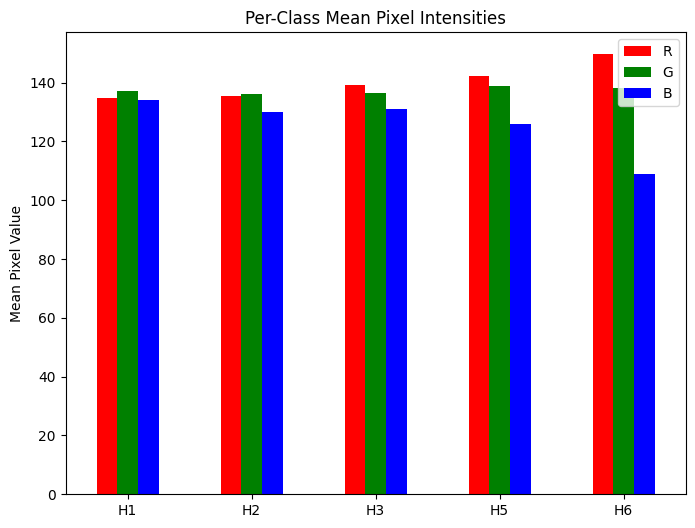

In [ ]:
means = {}

# Compute per-class mean pixel intensities
for folder_name in class_names:
    folder_path = os.path.join(data_dir, folder_name)
    imgs = [plt.imread(os.path.join(folder_path, fname)) for fname in os.listdir(folder_path)[:50]]
    imgs = np.array(imgs)
    class_mean = imgs.mean(axis=(0,1,2))
    means[folder_name] = class_mean
    print(f"{folder_name} mean per channel:", class_mean)

# Convert to DataFrame for plotting
df_means = pd.DataFrame(means, index=["R", "G", "B"]).T

colors = ["red", "green", "blue"]

# Plot pixel intensity means
ax = df_means.plot(kind="bar", figsize=(8,6), color=colors)
plt.ylabel("Mean Pixel Value")
plt.title("Per-Class Mean Pixel Intensities")
plt.xticks(rotation=0)
plt.show()

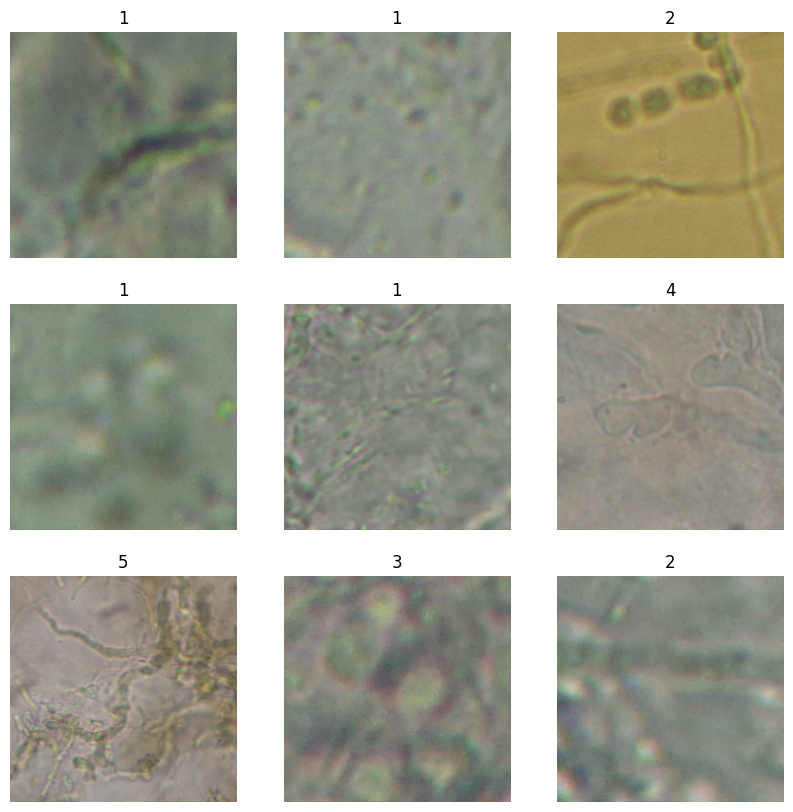

In [ ]:
# Plot images from training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i])+1)
        plt.axis("off")

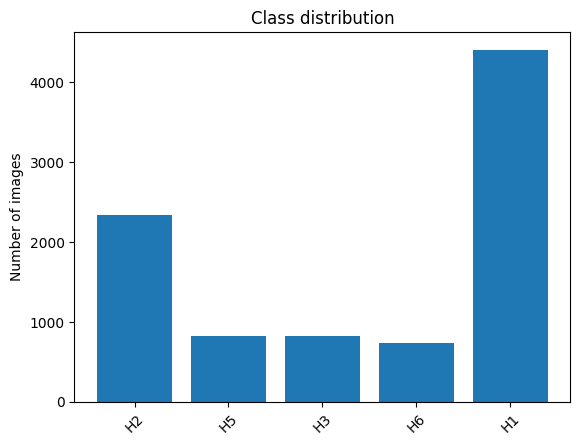

Class counts: {'H2': 2334, 'H5': 818, 'H3': 819, 'H6': 739, 'H1': 4404}


In [ ]:
# Plot class distribution in training dataset
class_counts = {}

for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_counts[class_dir.name] = len(list(class_dir.glob("*.jpg"))) + len(list(class_dir.glob("*.png")))

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Number of images")
plt.title("Class distribution")
plt.show()

print("Class counts:", class_counts)


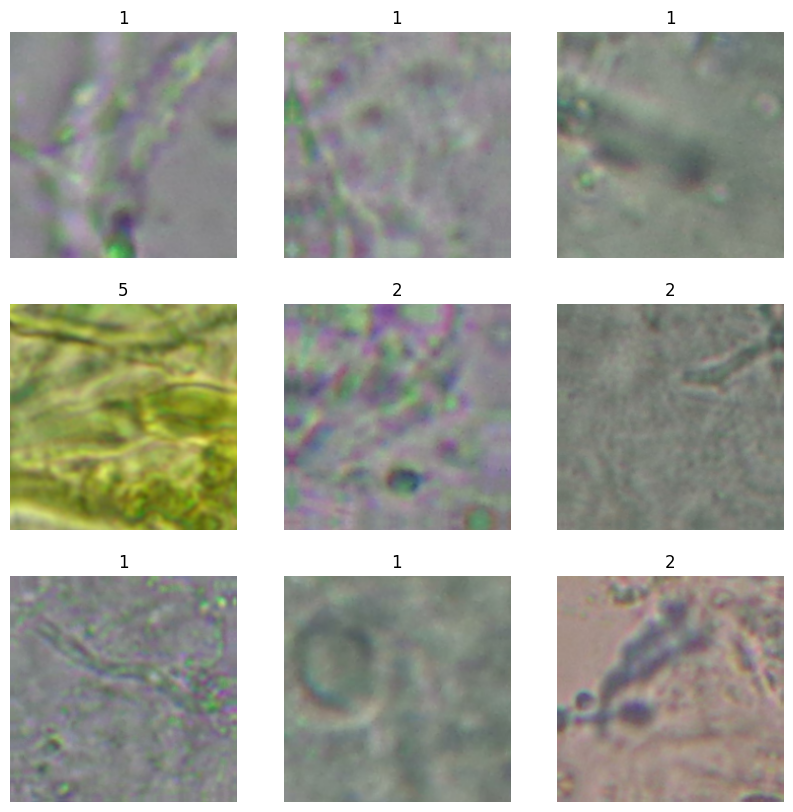

In [ ]:
# Apply data augmentation to training dataset
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
], name="augment")

#Visualize images after augmentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        aug_img = data_augmentation(images)[i].numpy().astype("uint8")
        ax = plt.subplot(3, 3, i + 1)
        plt.title(int(labels[i])+1)
        plt.imshow(aug_img)
        plt.axis("off")
    break


### Model Procedures
This project utilized two convolutional neural network (CNN) models—EfficientNetB0 and ResNet50—to classify fungal images into five classes, leveraging pretrained weights and transfer learning for improved performance.

- EfficientNetB0:
EfficientNetB0 was selected for its state-of-the-art architecture and efficiency on medium-resolution images. The model was initialized with ImageNet weights and trained in two phases:
- Phase 1: Base layers were frozen to train only the classifier head, consisting of:
    - Fully connected layer with 256 units and ReLU activation
    - Dropout layer (0.4) for regularization
- Phase 2: The top 40 layers of the base were unfrozen for fine-tuning, allowing the model to adapt pretrained features to the fungal dataset while mitigating overfitting.
- Training details:
    - Optimizer: Adam (learning rate 1e-3 for head, 1e-5 for fine-tuning)
    - Class weights were applied to address the imbalanced dataset
    - Callbacks: EarlyStopping and ReduceLROnPlateau for adaptive learning and convergence
- Evaluation: Model performance was assessed via accuracy, per-class F1 scores, ROC-AUC, and confusion matrices.

ResNet50 (with Hyperparameter Tuning):
ResNet50 was chosen as a complementary architecture to evaluate the impact of hyperparameter optimization:
 - Hyperparameters tuned using KerasTuner RandomSearch included:
    - Number of unfrozen layers (10–40)
    - Dropout rate (0.3–0.7)
    - Learning rate (1e-3, 1e-4, 1e-5)
- The best hyperparameters were selected based on validation accuracy.
- Training details:
    - Class-weighted loss to address imbalanced classes
    - ModelCheckpoint and EarlyStopping callbacks saved the best-performing weights
    - Trained for 20 epochs with head training and fine-tuning

Overfitting and Class Imbalance Handling:
- Dropout layers and selective fine-tuning were used to prevent overfitting.
- Computed class weights ensured that minority classes contributed appropriately to the loss function.

Model Evaluation and Comparison:
- Both models were evaluated on the same validation set using ROC-AUC, confusion matrices, and classification reports.
- EfficientNetB0 showed stronger performance on certain minority classes (H3 and H6), while ResNet50 exhibited more consistent performance across all classes, likely due to hyperparameter tuning.
- Best-performing weights were saved for both models, enabling reproducibility and comparison.

In [ ]:
# Compute class weights to handle class imbalance
all_labels = []
for _, labels in train_ds.unbatch().as_numpy_iterator():
    all_labels.append(int(labels))
all_labels = np.array(all_labels, dtype=int)

classes = np.arange(len(class_names))
class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=all_labels
)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_values)}
print("Class weights:", class_weights)


Class weights: {0: 0.4138518308260006, 1: 0.7809319764327799, 2: 2.2259541984732825, 3: 2.229357798165138, 4: 2.467005076142132}


In [ ]:
# Create efficientnet model
base = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"
)
base.trainable = False  # Phase 1: freeze

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
model.summary()


In [ ]:
# Create model checkpoints and callbacks
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("models", exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "checkpoints/best_model.keras", save_best_only=True, monitor="val_accuracy"
    ),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

# Phase 1: train head
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# Phase 2: fine-tune upper layers
base.trainable = True
# Unfreeze only the top N layers/blocks to reduce overfitting
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # lower LR for fine-tuning
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

model.save("models/final_model.keras")

# Export saved model
model.export("models/final_model_savedmodel")


In [ ]:
# Load the best efficientnet model
best_model = keras.models.load_model("checkpoints/best_model.keras")

In [ ]:
# Build ResNet model with hyperparameter tuning
def build_resnet(hp):
    base_model = keras.applications.ResNet50(
        include_top=False,
        input_shape=image_size + (3,),
        pooling='avg',
        weights='imagenet'
    )

    # Tune number of layers to unfreeze
    unfreeze_layers = hp.Int('unfreeze', 10, 40, step=10)
    for single_layer in base_model.layers[:-unfreeze_layers]:
        single_layer.trainable = False

    x = keras.layers.Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1))(base_model.output)
    layer_outputs = keras.layers.Dense(5, activation='softmax')(x)
    resnet_model = keras.Model(base_model.input, layer_outputs)

    # Tune learning rate
    lr = hp.Choice('lr', [1e-3, 1e-4, 1e-5])
    resnet_model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return resnet_model

tuner = kt.RandomSearch(
    build_resnet,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='resnet_tuning'
)

tuner.search(train_ds, validation_data=val_ds, epochs=10)
best_hp = tuner.get_best_hyperparameters()[0]


Trial 10 Complete [00h 51m 56s]
val_accuracy: 0.7669956088066101

Best val_accuracy So Far: 0.8464912176132202
Total elapsed time: 16h 39m 51s


In [41]:
# Build the model with the best hyperparameters
best_resnet_model = build_resnet(best_hp)

# Save the best weights during training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "checkpoints/best_resnet.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    )
]

# Train the model with the best hyperparameters
history = best_resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

best_resnet_model.save("models/final_resnet_model.keras")

# Export a TensorFlow SavedModel directory
best_resnet_model.export("models/final_resnet_model_savedmodel")

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6513 - loss: 0.9652
Epoch 1: val_accuracy improved from -inf to 0.65899, saving model to checkpoints/best_resnet.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.6518 - loss: 0.9635 - val_accuracy: 0.6590 - val_loss: 1.3216
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8222 - loss: 0.4662
Epoch 2: val_accuracy improved from 0.65899 to 0.71765, saving model to checkpoints/best_resnet.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.8223 - loss: 0.4660 - val_accuracy: 0.7177 - val_loss: 0.6771
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8744 - loss: 0.3157
Epoch 3: val_accuracy improved from 0.71765 to 0.77193, saving model to checkpoints/best_resnet.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.8745 - loss: 0.3155 - val_accuracy: 0.7719 - val_loss: 0.6968
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9181 - loss: 0.2438
Epo

INFO:tensorflow:Assets written to: models/final_resnet_model_savedmodel/assets


Saved artifact at 'models/final_resnet_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_356')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  14574428400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14574429632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14574427472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14574425536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14574426416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14574424304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14239696144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14239696320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14240196912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14240194624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14240133184: TensorSpec(shape=

In [ ]:
# Load the best resnet model
best_resnet_model = keras.models.load_model("checkpoints/best_resnet.keras")

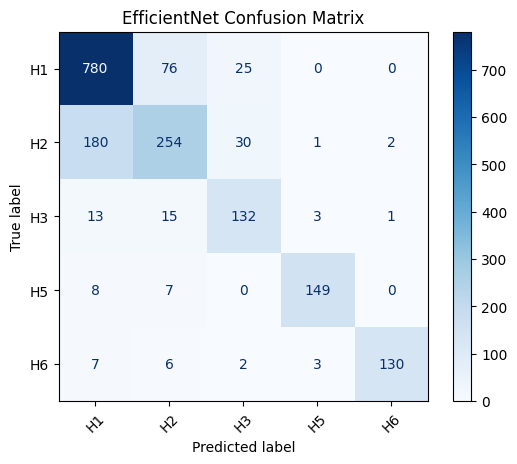

Efficient Net Classification report:
              precision    recall  f1-score   support

          H1     0.7895    0.8854    0.8347       881
          H2     0.7095    0.5439    0.6158       467
          H3     0.6984    0.8049    0.7479       164
          H5     0.9551    0.9085    0.9313       164
          H6     0.9774    0.8784    0.9253       148

    accuracy                         0.7922      1824
   macro avg     0.8260    0.8042    0.8110      1824
weighted avg     0.7910    0.7922    0.7869      1824



In [35]:
# Get true and predicted labels for efficientnet
y_true = np.concatenate([labels.numpy() for _, labels in val_ds], axis=0)
y_prob_en = best_model.predict(val_ds, verbose=0)
y_pred_en = np.argmax(y_prob_en, axis=1)

cm = confusion_matrix(y_true, y_pred_en, labels=np.arange(len(class_names)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("EfficientNet Confusion Matrix")
plt.show()

# Classification reports
print("Efficient Net Classification report:")
print(classification_report(y_true, y_pred_en, target_names=class_names, digits=4))

2025-09-26 16:54:35.179394: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


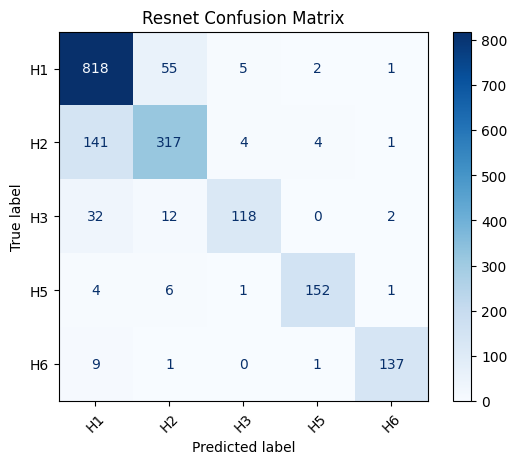

Resnet Classification report:
              precision    recall  f1-score   support

          H1     0.8147    0.9285    0.8679       881
          H2     0.8107    0.6788    0.7389       467
          H3     0.9219    0.7195    0.8082       164
          H5     0.9560    0.9268    0.9412       164
          H6     0.9648    0.9257    0.9448       148

    accuracy                         0.8454      1824
   macro avg     0.8936    0.8359    0.8602      1824
weighted avg     0.8482    0.8454    0.8423      1824



In [36]:
# Get true and predicted labels
y_true_resnet = np.concatenate([labels.numpy() for _, labels in val_ds], axis=0)
y_prob_resnet = best_resnet_model.predict(val_ds, verbose=0)
y_pred_resnet = np.argmax(y_prob_resnet, axis=1)

cm_resnet = confusion_matrix(y_true, y_pred_resnet, labels=np.arange(len(class_names)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Resnet Confusion Matrix")
plt.show()

# Classification reports
print("Resnet Classification report:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names, digits=4))

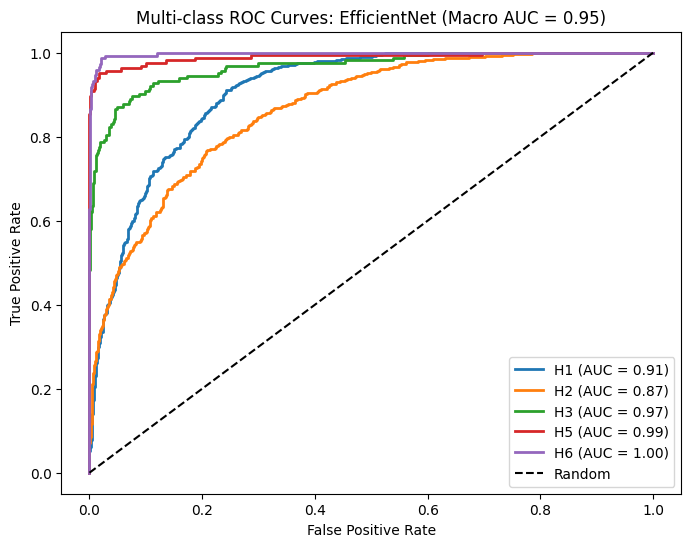

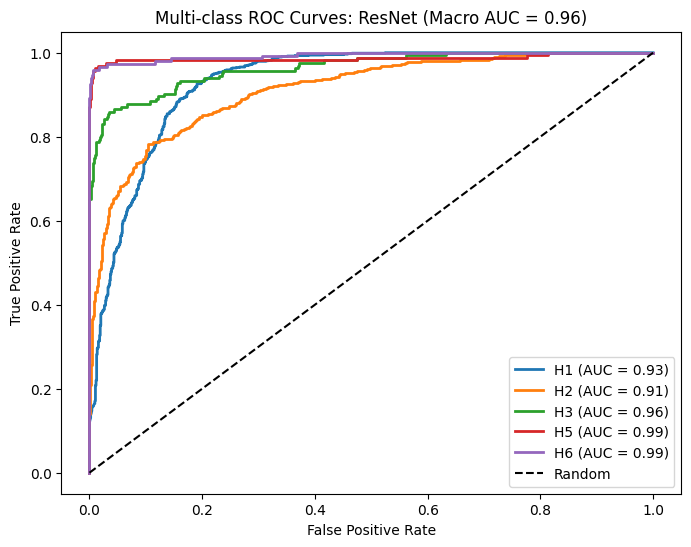

EfficientNet Macro ROC AUC: 0.9456
ResNet Macro ROC AUC: 0.9569


In [25]:
# One-hot encode the true labels for multi-class ROC
y_true = label_binarize(y_true, classes=np.arange(len(class_names)))

def plot_multiclass_roc(y_true_bin, y_prob, model_name):
    plt.figure(figsize=(8, 6))
    n_classes = y_true_bin.shape[1]

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    # Macro-average ROC AUC
    macro_roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curves: {model_name} (Macro AUC = {macro_roc_auc:.2f})')
    plt.legend(loc='lower right')
    plt.show()

    return macro_roc_auc

# EfficientNet
macro_auc_eff = plot_multiclass_roc(y_true, y_prob_en, "EfficientNet")

# ResNet
macro_auc_res = plot_multiclass_roc(y_true, y_prob_resnet, "ResNet")

# Compare macro AUCs
print(f"EfficientNet Macro ROC AUC: {macro_auc_eff:.4f}")
print(f"ResNet Macro ROC AUC: {macro_auc_res:.4f}")



### Results and Analysis
This project applied two deep learning models—EfficientNetB0 and ResNet50—for multiclass classification of fungal images. The analysis focused on overall performance, per-class performance, and model comparison to highlight strengths, limitations, and potential improvements.

EfficientNetB0:
- Achieved an overall accuracy of 79.2% and a macro ROC AUC of 0.9456.
- Per-class performance:
    - H3 and H6 had relatively strong classification results compared to other minority classes.
    - H2 and H1 were more challenging for this model to identify.

Strengths: EfficientNetB0 performed particularly well on smaller classes (H3 and H6), suggesting good feature extraction for minority samples.

ResNet50 (with Hyperparameter Tuning):
- Achieved an overall accuracy of 84.5% and a macro ROC AUC of 0.9569.
- Per-class performance:
    - Strong across majority and minority classes (H1–H6), with improved precision and recall compared to EfficientNetB0.
    - Hyperparameter tuning (unfreeze layers, dropout, learning rate) contributed to overall performance gains, particularly for majority classes.

Model Comparison and Insights:
- Per-class ROC AUC indicates that EfficientNetB0 outperformed ResNet50 on H3 and H6, highlighting its ability to capture relevant features in minority classes without hyperparameter tuning.
- ResNet50’s superior overall performance demonstrates the benefit of hyperparameter optimization for deep networks, particularly in handling imbalanced datasets.
- Future Considerations: EfficientNetB0’s performance could likely be improved with systematic tuning of learning rate, dropout, and fine-tuned layers.

Visual Interpretations:
- ROC Curves per Class: ROC curves show class-wise performance differences, emphasizing EfficientNetB0’s strengths on H3 and H6 and ResNet50’s consistent performance across all classes.
- Confusion Matrices: Highlight misclassifications for each model, showing that ResNet50 significantly reduces classification for H1 and H2 when compared to EfficientNetB0.

### Discussion and Conclusion
This project explored fungal image classification using two state-of-the-art convolutional neural networks: EfficientNetB0 and ResNet50. Both models leveraged transfer learning with ImageNet weights and were evaluated on a five-class dataset with class imbalance.

EfficientNetB0:
EfficientNetB0 was trained without hyperparameter tuning, using a frozen base initially and fine-tuning the top layers.The model trained faster and required less GPU memory compared to ResNet50, making it efficient for iterative experimentation. Overall accuracy was slightly lower than ResNet50, but per-class performance revealed that EfficientNetB0 performed better on minority classes H3 and H6. However, confusion between majority classes H1 and H2 was more pronounced, highlighting a limitation in handling these two classes.

ResNet50 with Hyperparameter Tuning:
ResNet50 underwent hyperparameter optimization via KerasTuner, tuning the number of unfrozen layers, dropout rate, and learning rate. This model achieved higher overall accuracy and better class-specific performance on H1 and H2, the classes most confused by EfficientNetB0.Fine-tuning the hyperparameters allowed ResNet50 to balance generalization and specialization across all classes, improving both weighted and macro-average metrics.

Trade-offs and Insights
- Training speed vs. performance: EfficientNetB0 trained significantly faster, making it more suitable when performance is prioritzed. ResNet50, while slower, benefited from hyperparameter tuning and achieved higher per-class and overall accuracy.
- Class-specific behavior: EfficientNetB0 excelled on minority classes but struggled with majority class separation, suggesting that hyperparameter tuning or additional class-balancing techniques (e.g., focal loss, oversampling) could further improve its performance.
- Hyperparameter tuning benefits: The comparison highlights the importance of hyperparameter optimization. While EfficientNetB0 has strong baseline performance, careful tuning could likely reduce class confusion and narrow the performance gap with ResNet50.

Areas for Improvement
- Explore hyperparameter tuning for EfficientNetB0 to improve performance on the majority classes H1 and H2.
- Investigate alternative strategies to handle class imbalance, such as focal loss, weighted sampling, or SMOTE for images.
- Evaluate ensemble approaches combining EfficientNetB0 and ResNet50 predictions to leverage complementary strengths.
- Test model scalability on larger datasets or different biological image domains to assess generalization.

In summary, EfficientNetB0 provided a fast, baseline model with promising results on minority classes, while ResNet50 with hyperparameter tuning achieved higher overall and per-class accuracy, particularly for majority classes. These results underscore the trade-offs between training efficiency and predictive performance. It aldo demonstrate the value of hyperparameter tuning in improving CNN-based classification on imbalanced, real-world image datasets.